In [2]:
import numpy as np
import torch
# At the start of your notebook
from IPython.display import clear_output
import gc

# After heavy computations
clear_output(wait=True)
gc.collect()

73

In [3]:
from steps import setup_and_train_models, analyze_seizure_propagation

In [4]:
RESULT_FOLDER = "result"
MODEL_FOLDER = "model"
model_names = ['Wavenet']  # 'CNN1D', 'Wavenet', 'LSTM'

In [5]:
# Do batch analysis to find the best hyperparameters
seizures = [1, 2, 3, 5, 7]
thresholds = [0.8]
smooth_windows = [80]

In [9]:
results, models = setup_and_train_models(
    data_folder="data",
    model_folder="checkpoints",
    model_names=model_names,  # Only use CNN1D and Wavenet
    train=False,
    params={'epochs': 60, 'batch_size': 4096}
)

Removed 0 zero-padded samples out of 143136 total samples
Using 143136 samples from each class for balanced dataset
Final dataset shapes - Training: (229017, 1, 128), Validation: (57255, 1, 128)
Removed 0 zero-padded samples out of 21056 total samples
Using 21056 samples from each class for balanced dataset
Final dataset shapes - Training: (33689, 1, 128), Validation: (8423, 1, 128)
Removed 29570 zero-padded samples out of 225000 total samples
Using 98000 samples from each class for balanced dataset
Final dataset shapes - Training: (156800, 1, 128), Validation: (39200, 1, 128)


In [10]:
results_propagation_total = []
model_name = 'Wavenet'
model = models[model_name]
threshold = 0.8
smooth_window = 80
for PAT_NO in [65, 66]:
    for seizure_no in seizures:
        if PAT_NO == 66 and seizure_no > 3:
            continue
        params = {
            'threshold': threshold,
            'smooth_window': smooth_window,
            'n_seconds': 60,
            'seizure_start': 10,
        }
        results_propagation = analyze_seizure_propagation(
            patient_no=PAT_NO,
            seizure_no=seizure_no,
            model=model,
            data_folder='data',
            params=params,
            save_results_ind=True
        )
        results_propagation_total.append(results_propagation)

Results saved to: result\P65\Seizure1\analysis_results
Results saved to: result\P65\Seizure2\analysis_results
Results saved to: result\P65\Seizure3\analysis_results
Results saved to: result\P65\Seizure5\analysis_results
Results saved to: result\P65\Seizure7\analysis_results
Results saved to: result\P66\Seizure1\analysis_results
Results saved to: result\P66\Seizure2\analysis_results
Results saved to: result\P66\Seizure3\analysis_results


In [11]:
import torch
from torch.utils.data import DataLoader
from datasetConstruct import CustomDataset
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
def construct_single_dataset(results_propagation, window_size, overlap=0.5):
    """
    Constructs dataset by sliding window over smoothed probabilities to create N-second segments.
    
    Args:
        results_propagation: Dictionary containing smoothed_probabilities and true_seizure_channels
        window_size: Size of window in seconds
        overlap: Overlap fraction between consecutive windows (default 0.5 for 50% overlap)
    
    Returns:
        X: Array of resampled segments 
        y: Array of corresponding labels
    """
    # Get raw data excluding first 50 timepoints
    raw_data = results_propagation['smoothed_probabilities'][50:, :]
    
    # Calculate window parameters
    window_length = window_size * 5  # 5 samples per second
    
    # Check if data is long enough for at least one window
    if len(raw_data) < window_length:
        print(f"Warning: Data length {len(raw_data)} is shorter than window length {window_length}")
        # Pad with zeros if needed
        padding = np.zeros((window_length - len(raw_data), raw_data.shape[1]))
        raw_data = np.vstack([raw_data, padding])
    
    step_size = int(window_length * (1 - overlap))  # Step size based on overlap
    
    # Ensure at least one complete segment
    if step_size == 0:
        step_size = 1
    
    # Calculate number of complete segments
    num_segments = (len(raw_data) - window_length) // step_size + 1
    
    # If no complete segments possible, create just one segment
    if num_segments <= 0:
        num_segments = 1
        
    # Initialize arrays
    X = np.zeros((num_segments, window_length, raw_data.shape[1]))
    y = np.zeros((num_segments, raw_data.shape[1]))
    
    # Create segments using sliding window
    for i in range(num_segments):
        start_idx = i * step_size
        end_idx = start_idx + window_length
        
        # Handle case where end_idx exceeds data length
        if end_idx > len(raw_data):
            # Pad with zeros
            segment = raw_data[start_idx:, :]
            padding = np.zeros((end_idx - len(raw_data), raw_data.shape[1]))
            X[i] = np.vstack([segment, padding])
        else:
            # Extract segment normally
            X[i] = raw_data[start_idx:end_idx, :]
        
        # Assign labels
        y[i][results_propagation['true_seizure_channels']] = 1
        
    X = np.transpose(X, (1, 0, 2))
    # Combine the first two dimensions
    X = np.concatenate([X[i] for i in range(X.shape[0])], axis=0)
    y = y.flatten()
    
    return X, y, X, y

def construct_channel_recognition_dataset(results_propagation_total, seizure_onset_window_size=60, batch_size=64, split=0.8):
    """
    Constructs balanced datasets for seizure channel recognition and onset detection.
    
    Args:
        results_propagation_total: List of dictionaries containing seizure data
        seizure_onset_window_size: Window size in seconds (default: 60)
        batch_size: Size of training batches (default: 64)
        split: Train/validation split ratio (default: 0.8)
    
    Returns:
        Four DataLoaders: train/val for channel recognition and train/val for onset detection
    """
    
    def process_dataset(x_data, y_data, split, batch_size):
        """Helper function to reduce code duplication"""
        # Balance dataset
        pos_idx = np.where(y_data == 1)[0]
        neg_idx = np.where(y_data == 0)[0]
        n_samples = min(len(pos_idx), len(neg_idx))
        
        # Sample equal numbers
        indices = np.concatenate([
            np.random.choice(pos_idx, n_samples, replace=False),
            np.random.choice(neg_idx, n_samples, replace=False)
        ])
        indices = np.random.permutation(indices)
        
        x_data, y_data = x_data[indices], y_data[indices]
        
        # Split data
        sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split, random_state=0)
        train_idx, val_idx = next(sss.split(x_data, y_data))
        
        # Create datasets and loaders
        train_loader = DataLoader(
            CustomDataset(x_data[train_idx], y_data[train_idx]),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = DataLoader(
            CustomDataset(x_data[val_idx], y_data[val_idx]),
            batch_size=1,
            shuffle=True
        )
        
        return train_loader, val_loader

    # Collect data from all samples
    x_total, y_total = [], []
    x_onset_total, y_onset_total = [], []
    
    for results in results_propagation_total:
        x, y, x_onset, y_onset = construct_single_dataset(
            results, 
            seizure_onset_window_size
        )
        x_total.append(x)
        y_total.append(y)
        x_onset_total.append(x_onset)
        y_onset_total.append(y_onset)
    
    # Process channel recognition data
    x_total = np.expand_dims(np.concatenate(x_total, axis=1).T, axis=1)
    y_total = np.concatenate(y_total)
    
    channel_train, channel_val = process_dataset(
        x_total, y_total, split, batch_size
    )
    
    # Process onset detection data 
    x_onset_total = np.expand_dims(np.concatenate(x_onset_total, axis=1).T, axis=1)
    y_onset_total = np.concatenate(y_onset_total)
    
    onset_train, onset_val = process_dataset(
        x_onset_total, y_onset_total, split, batch_size
    )
    
    return channel_train, channel_val, onset_train, onset_val

In [33]:
seizure_channels_dataset_train, seizure_channels_dataset_val, seizure_onset_dataset_train, seizure_onset_dataset_val = construct_channel_recognition_dataset(results_propagation_total, 20, batch_size=512)

In [34]:
from models import Wavenet, train_using_optimizer

In [35]:
# Define the model
model_seizure_channel = Wavenet(input_dim=1, output_dim=2, lr=0.001, hidden_dim=64, kernel_size=64, dropout=0.5)
# model_seizure_onset = Wavenet2(input_dim=1, output_dim=2, lr=0.001, hidden_dim=64, kernel_size=64, dropout=0.5)

# Train the model
train_loss, val_loss, val_accuracy = train_using_optimizer(model_seizure_channel, seizure_channels_dataset_train, seizure_channels_dataset_val, epochs=200, checkpoint_freq=20)
# train_ons_loss, val_ons_loss, val_ons_accuracy = train_using_optimizer(model_seizure_onset, seizure_onset_dataset_train, seizure_onset_dataset_val, epochs=200, checkpoint_freq=100)

Epoch 20/200: 100%|██████████| 17/17 [00:00<00:00, 72.49it/s, loss=0.6975, avg_loss=0.6915]


Epoch [20/200]
Training Loss: 0.6915
Validation Loss: 0.6912
Validation Accuracy: 0.5227


Epoch 40/200: 100%|██████████| 17/17 [00:00<00:00, 70.71it/s, loss=0.6880, avg_loss=0.6882]


Epoch [40/200]
Training Loss: 0.6882
Validation Loss: 0.6906
Validation Accuracy: 0.5279


Epoch 60/200: 100%|██████████| 17/17 [00:00<00:00, 71.28it/s, loss=0.6900, avg_loss=0.6887]


Epoch [60/200]
Training Loss: 0.6887
Validation Loss: 0.6899
Validation Accuracy: 0.5346


Epoch 80/200: 100%|██████████| 17/17 [00:00<00:00, 75.27it/s, loss=0.6915, avg_loss=0.6881]


Epoch [80/200]
Training Loss: 0.6881
Validation Loss: 0.6890
Validation Accuracy: 0.5426


Epoch 100/200: 100%|██████████| 17/17 [00:00<00:00, 95.51it/s, loss=0.6788, avg_loss=0.6876]


Epoch [100/200]
Training Loss: 0.6876
Validation Loss: 0.6882
Validation Accuracy: 0.5407


Epoch 120/200: 100%|██████████| 17/17 [00:00<00:00, 35.64it/s, loss=0.6877, avg_loss=0.6867]


Epoch [120/200]
Training Loss: 0.6867
Validation Loss: 0.6885
Validation Accuracy: 0.5379


Epoch 140/200: 100%|██████████| 17/17 [00:00<00:00, 72.03it/s, loss=0.6739, avg_loss=0.6865]


Epoch [140/200]
Training Loss: 0.6865
Validation Loss: 0.6884
Validation Accuracy: 0.5421


Epoch 160/200: 100%|██████████| 17/17 [00:00<00:00, 86.73it/s, loss=0.6870, avg_loss=0.6871]


Epoch [160/200]
Training Loss: 0.6871
Validation Loss: 0.6885
Validation Accuracy: 0.5388


Epoch 180/200: 100%|██████████| 17/17 [00:00<00:00, 76.40it/s, loss=0.6902, avg_loss=0.6868]


Epoch [180/200]
Training Loss: 0.6868
Validation Loss: 0.6878
Validation Accuracy: 0.5450


Epoch 200/200: 100%|██████████| 17/17 [00:00<00:00, 100.89it/s, loss=0.7015, avg_loss=0.6870]


Epoch [200/200]
Training Loss: 0.6870
Validation Loss: 0.6889
Validation Accuracy: 0.5450


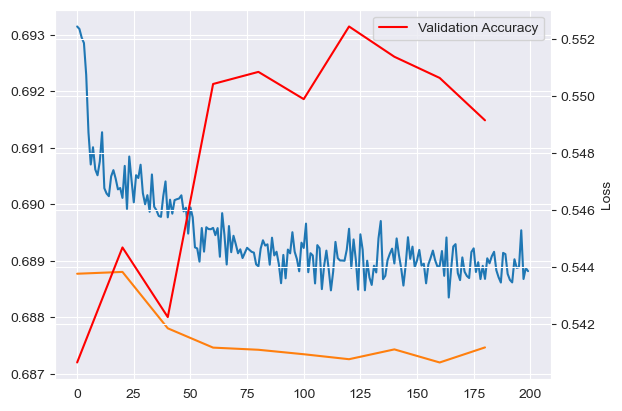

In [17]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

x_ticks = range(0, 200, 20)

plt.plot(train_loss, label='Train')
plt.plot(x_ticks, val_loss, label='Validation')
# Twin the y-axis for accuracy of validation
plt.twinx()
plt.plot(x_ticks, val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('result/loss_seizure_channels.png')

plt.show()



In [27]:
predicted_labels_total = []

time_lengths = [10, 20, 30, 40, 50, 60]

for i in range(len(results_propagation_total)):

    sample_seizure = results_propagation_total[i]['smoothed_probabilities'][50:100, :]
    
    # Feed the data to the model and get predictions
    sample_seizure = sample_seizure.T
    sample_seizure = np.expand_dims(sample_seizure, axis=1)
    
    # Convert to tensor
    sample_seizure = torch.tensor(sample_seizure, dtype=torch.float32)
    
    # Get the predictions
    predictions = model_seizure_channel(sample_seizure)
    
    # Get the predicted labels, where predicted_labels = 1 when chance is more than 80%
    predicted_labels = predictions.detach().to('cpu').numpy()
    
    predicted_labels = predicted_labels[:, 1] > 0.5
    
    predicted_labels_total.append(predicted_labels)

In [28]:
# Convert the channel from results_propagation to the y_true as 1s and 0s
gound_truth_total = []
for i in range(len(results_propagation_total)):
    y_true = np.zeros(results_propagation_total[i]['smoothed_probabilities'].shape[1])
    y_true[results_propagation_total[i]['true_seizure_channels']] = 1
    gound_truth_total.append(y_true)
    
# Convert the gound_truth_total to a single array
gound_truth_total = np.concatenate(gound_truth_total)

# Convert the predicted_labels_total to a single array
predicted_labels_total = np.concatenate(predicted_labels_total)

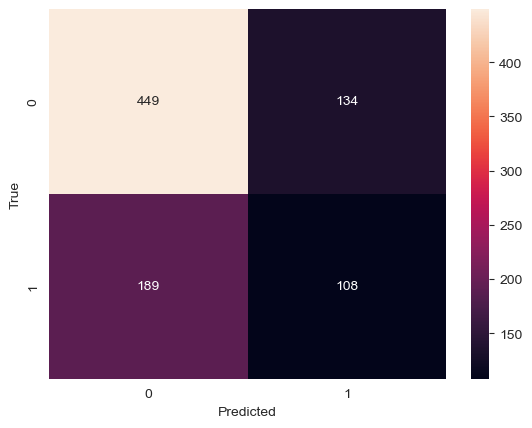

In [29]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(gound_truth_total.flatten(), predicted_labels_total.flatten())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('result/confusion_matrix_seizure_channels.png')

plt.show()


In [ ]:
# Calculate the accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(gound_truth_total.flatten(), predicted_labels_total.flatten())
precision = precision_score(gound_truth_total.flatten(), predicted_labels_total.flatten())
recall = recall_score(gound_truth_total.flatten(), predicted_labels_total.flatten())
f1 = f1_score(gound_truth_total.flatten(), predicted_labels_total.flatten())

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')